Notebook contributed by Rachel Mandelbaum (@rmandelb)

Last Verified to Run: 2019-02-11 (by @rmandelb)

This notebook illustrates some basic analysis of the galaxy populations for Run 1.2i/p.  Because of some known issues with these test runs, the analysis is a bit more complicated than it will be for future runs.  In particular, the fact that Run 1.2p has a bug that results in no extinction being applied (galaxy internal extinction or MW extinction) while Run 1.2i does include extinction means that even with the same input catalogs, the galaxy populations are not expected to look the same.  The implications of this are explored in various places below.

Work on this notebook also contributed to validation of DM outputs for Run 1.2i and to better understanding of data products needed for Run 1.2x:

1. Some issues were found with the object catalogs in Run 1.2i, c.f. https://github.com/LSSTDESC/DC2-production/issues/308; the current version of this notebook uses a reprocessed tract for which this problem was fixed.

2. It became clear that the truth catalogs for Run 1.2 as of January 2019 can only be used to analyze Run 1.2p data, since they do not include extinction effects.  See this slack discussion: https://lsstc.slack.com/archives/CB30ND9CG/p1546459017026100. Future truth catalogs include extincted quantities but for now there is no Run 1.2i truth comparison.

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
from GCR import GCRQuery
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [2]:
# Establish some basic quantities up top.
#
# What tract will we use everywhere for the Run 1.2x?  
# The tract below was chosen as an example; it's fine to use others.
tract_num = 4850
# Magnitude cut in i-band, determined such that galaxies in the coadd should be well-detected
# (a reasonably complete sample far from the flux limit).
max_mag_i = 25.0

In [17]:
# Load the object catalogs for Run 1.2x and for the HSC XMM field.  We want to check the reference band information, which is not available
# in the smaller 'dc2_object_run1.2x' catalogs, so that's why we use the larger versions with all columns.
catalog_i = GCRCatalogs.load_catalog('dc2_object_run1.2i_all_columns')
catalog_p = GCRCatalogs.load_catalog('dc2_object_run1.2p_all_columns')
catalog_h = GCRCatalogs.load_catalog('hsc-pdr1-xmm')

In [18]:
# Establish some basic cuts intended to yield a galaxy sample with reasonable flux measurements.
basic_cuts = [
    GCRQuery('extendedness > 0'),     # Extended objects (primarily galaxies)
    GCRQuery((np.isfinite, 'mag_i_cModel')),  # Select objects that have i-band cmodel magnitudes
    GCRQuery('clean'), # The source has no flagged pixels (interpolated, saturated, edge, clipped...) 
                       # and was not skipped by the deblender
    GCRQuery('xy_flag == 0'),                                      # Flag for bad centroid measurement
]

In [19]:
# Define cuts on galaxy properties: currently we simply make a sample limited at i<25.
properties_cuts = [
    GCRQuery('mag_i_cModel < %f'%max_mag_i),
]

In [20]:
# We can now extract our sample with basic and property cuts.  Should decide first what quantities we want.
quantities_sim = ['mag_i_cModel', 'snr_i_cModel', 'ra', 'dec', 'mag_g_cModel', 'mag_r_cModel', 
                  'magerr_i_cModel', 'psf_fwhm_i', 'Ixx_i', 'Ixy_i', 'Iyy_i',
                  'psFlux_i', 'psFluxErr_i',
                  'merge_measurement_u', 'merge_measurement_g', 'merge_measurement_r', 'merge_measurement_i', 'merge_measurement_z', 'merge_measurement_y']
quantities = ['mag_i_cModel', 'snr_i_cModel', 'ra', 'dec', 'mag_g_cModel', 'mag_r_cModel', 
              'magerr_i_cModel', 'psf_fwhm_i', 'Ixx_i', 'Ixy_i', 'Iyy_i']
data_basic_i = catalog_i.get_quantities(quantities_sim, 
                                        filters=basic_cuts+properties_cuts, 
                                        native_filters=['tract == %d'%tract_num])
data_basic_p = catalog_p.get_quantities(quantities_sim, 
                                        filters=basic_cuts+properties_cuts, 
                                        native_filters=['tract == %d'%tract_num])
# For HSC, there is no tract selection.
data_basic_h = catalog_h.get_quantities(quantities, 
                                        filters=basic_cuts+properties_cuts)

In [22]:
# Some basic diagnostics here.
print('Number of objects passing cuts in Run 1.2i, Run1.2p:')
print(len(data_basic_i['ra']), len(data_basic_p['ra']))
print('Which reference band for the objects in Run 1.2i?  Numbers are ugrizy:')
print(np.sum(data_basic_i['merge_measurement_u'].astype(int)),
      np.sum(data_basic_i['merge_measurement_g'].astype(int)),
      np.sum(data_basic_i['merge_measurement_r'].astype(int)),
      np.sum(data_basic_i['merge_measurement_i'].astype(int)),
      np.sum(data_basic_i['merge_measurement_z'].astype(int)),
      np.sum(data_basic_i['merge_measurement_y'].astype(int)))
print('Which reference band for the objects in Run 1.2p?  Numbers are ugrizy:')
print(np.sum(data_basic_p['merge_measurement_u'].astype(int)),
      np.sum(data_basic_p['merge_measurement_g'].astype(int)),
      np.sum(data_basic_p['merge_measurement_r'].astype(int)),
      np.sum(data_basic_p['merge_measurement_i'].astype(int)),
      np.sum(data_basic_p['merge_measurement_z'].astype(int)),
      np.sum(data_basic_p['merge_measurement_y'].astype(int)))

Number of objects passing cuts in Run 1.2i, Run1.2p:
78243 119258
Which reference band for the objects in Run 1.2i?  Numbers are ugrizy:
24 368 6140 69864 1544 303
Which reference band for the objects in Run 1.2p?  Numbers are ugrizy:
148 781 3704 110001 2911 1713


The numbers above illustrate basic object counts and choices of reference band.  The signature of https://github.com/LSSTDESC/DC2-production/issues/308 was that only u and g were reference bands for Run 1.2i in the original processing.  Now it's mostly i-band, as for Run 1.2p.

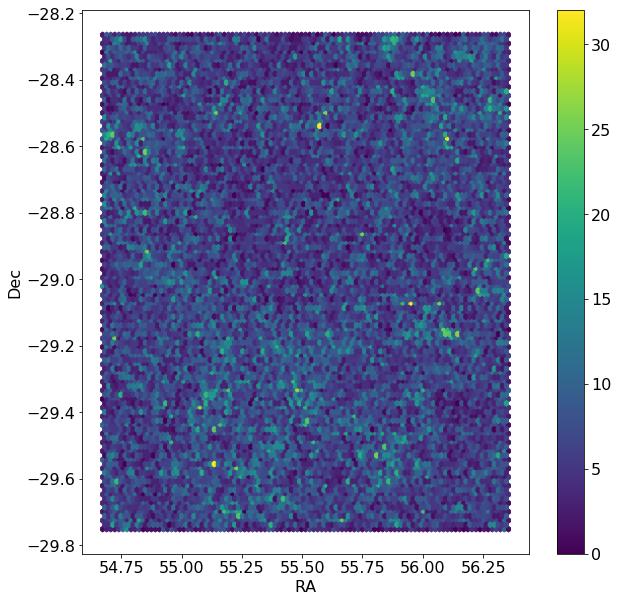

In [33]:
# Take a basic look at the tract, make sure its geometry is roughly rectangular on the sky (no major holes etc.).
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.hexbin(data_basic_i['ra'], data_basic_i['dec'])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

The geometry of the tract is very simple and rectangular, with only tiny holes, so we are going to use naive area estimates.

In [26]:
# Approximate area estimate for this tract assuming rectangle geometry.
ra_min = np.min(data_basic_i['ra'])
ra_max = np.max(data_basic_i['ra'])
dec_min = np.min(data_basic_i['dec'])
dec_max = np.max(data_basic_i['dec'])
delta_ra = ra_max-ra_min
delta_dec = dec_max-dec_min
cosdec = np.cos(np.median(data_basic_i['dec']*np.pi/180))
area_est = (delta_ra*cosdec)*delta_dec
print('Tract %d area is approximately %.2f square degrees'%(tract_num,area_est))
coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]

Tract 4850 area is approximately 2.19 square degrees


In [27]:
# Number density estimate in square arcmin
num_den_i = len(data_basic_i['ra']) / area_est / 60**2
num_den_p = len(data_basic_p['ra']) / area_est / 60**2
print('Number density for Run 1.2i, Run1.2p with consistent cuts in tract %d: %.1f, %.1f (per sq arcmin)'%(tract_num, num_den_i, num_den_p))

Number density for Run 1.2i, Run1.2p with consistent cuts in tract 4850: 9.9, 15.1 (per sq arcmin)


In [28]:
# Now we want to read in the truth catalog roughly within the area of this tract.  We select only non-sprinkled galaxies (not stars).
# Deal with different labeling of magnitude columns as well.  Important note: this truth catalog is currently only relevant for Run 1.2p, 
# because it only has magnitudes without internal or MW extinction.  To emphasize this, it's called truth_data_p rather than truth_data
mag_filters = [
    (np.isfinite, 'mag_i'),
    'mag_i < %f'%max_mag_i,
]
truth_cat = GCRCatalogs.load_catalog('dc2_truth_run1.2_static')
truth_cat.add_quantity_modifier('mag_i', truth_cat.get_quantity_modifier('mag_true_i'))
truth_cat.add_quantity_modifier('mag_g', truth_cat.get_quantity_modifier('mag_true_g'))
truth_cat.add_quantity_modifier('mag_r', truth_cat.get_quantity_modifier('mag_true_r'))
truth_cat.add_quantity_modifier('mag_z', truth_cat.get_quantity_modifier('mag_true_z'))
truth_native_filters = (coord_filters + ['i < %f'%max_mag_i, 'star==0', 'sprinkled==0'])
truth_data_p = truth_cat.get_quantities(['ra', 'dec', 'object_id', 'star', 'sprinkled', 'mag_i', 'mag_g', 'mag_r', 'mag_z'],
                                      filters=mag_filters, native_filters=truth_native_filters)
truth_num_den = len(truth_data_p['ra']) / area_est / 60**2

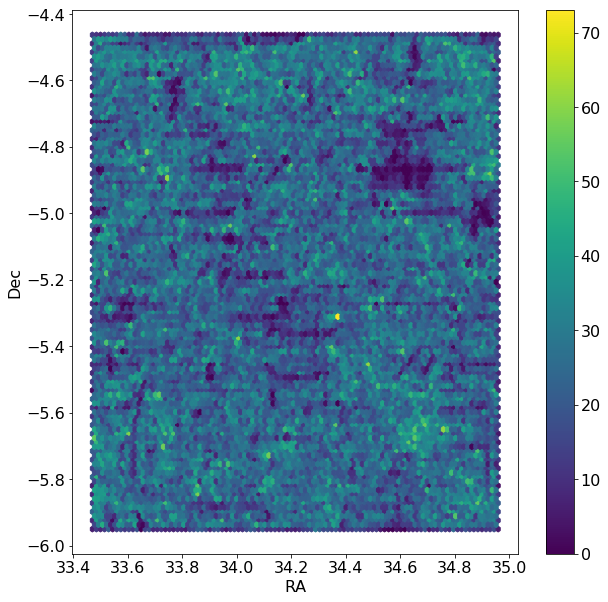

In [34]:
# Look at HSC coverage.  Just a few holes.
plt.figure(figsize=(10,10))
plt.subplot(111)
plt.hexbin(data_basic_h['ra'], data_basic_h['dec'])
plt.xlabel('RA')
plt.ylabel('Dec')
plt.colorbar()

In [30]:
# Approximate area estimate for HSC XMM catalog (turns out it is similar in area to the simulation tract we are inspecting)
ra_min = np.min(data_basic_h['ra'])
ra_max = np.max(data_basic_h['ra'])
dec_min = np.min(data_basic_h['dec'])
dec_max = np.max(data_basic_h['dec'])
delta_ra = ra_max-ra_min
delta_dec = dec_max-dec_min
cosdec = np.cos(np.median(data_basic_h['dec']*np.pi/180))
area_est_h = (delta_ra*cosdec)*delta_dec
print('HSC XMM approximate catalog area in sq deg: %.1f'%area_est_h)
num_den_h = len(data_basic_h['ra']) / area_est_h / 60**2

HSC XMM approximate catalog area in sq deg: 2.2


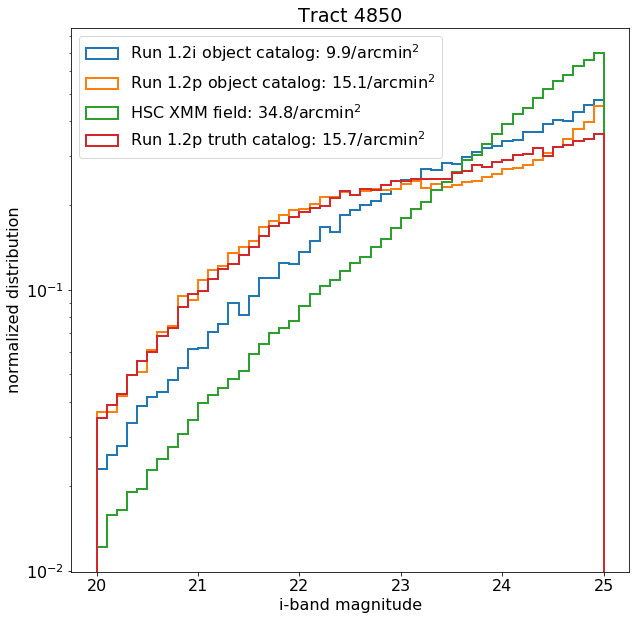

In [35]:
# Now we plot the *normalized* i-band magnitude distributions in Runs 2.1p, 2.1i, the truth catalog, and HSC.
# They are normalized so we can focus on the shape of the distribution.
# However, the legend indicates the total number density of galaxies selected with our magnitude cut,
# which lets us find issues with the overall number density matching (or not).
# Both Run 1.2i and Run 1.2p have colors that do not reflect the extragalactic catalogs, for reasons explained
# in https://github.com/LSSTDESC/DC2-production/issues/291.
plt.figure(figsize=(10,10))
plt.subplot(111)
nbins = 50
myrange = [20,max_mag_i]
plt.title('Tract %d'%tract_num)
data_to_plot = [
                data_basic_i['mag_i_cModel'],
                data_basic_p['mag_i_cModel'],
                data_basic_h['mag_i_cModel'],
                truth_data_p['mag_i']
]
labels_to_plot = [
    r'Run 1.2i object catalog: %.1f/arcmin$^2$'%num_den_i,
    r'Run 1.2p object catalog: %.1f/arcmin$^2$'%num_den_p,
    r'HSC XMM field: %.1f/arcmin$^2$'%num_den_h,
    r'Run 1.2p truth catalog: %.1f/arcmin$^2$'%truth_num_den
]
for ind in range(len(data_to_plot)):
    plt.hist(data_to_plot[ind], nbins, range=myrange, histtype='step',
            label=labels_to_plot[ind], linewidth=2.0, density=True)
plt.legend(loc='upper left')
plt.xlabel('i-band magnitude')
plt.ylabel('normalized distribution')
plt.yscale('log')

Some commentary on the results shown above:

- The HSC XMM field shows the number counts of galaxies in real data.  It follows a fairly typical power-law shape.  None of the simulations has as high of a normalization because they are based on an early version of protoDC2 that had a smaller density of galaxies for i<25 (this is a known offset).
- For Run 1.2p, the truth catalog (red) and the object catalogs (orange) show quite consistent number densities and shapes of the distributions.  This is a nice sanity check of the results.
- For Run 1.2i, the number counts and shape of the distribution differ from Run 1.2p.  Qualitatively, we expect this: Run 1.2p did not include extinction and Run 1.2i did, so there should be fewer detections in Run 1.2i.  However, a quantitative test is not possible until there is a truth catalog with extinction included.

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:780: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:781: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


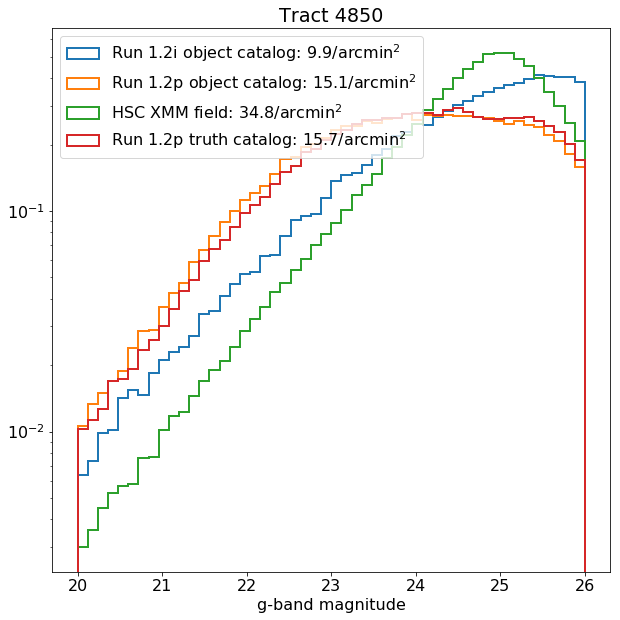

In [36]:
# Now g-band magnitude (but don't cut at the same place as in i-band).
plt.figure(figsize=(10,10))
plt.subplot(111)
myrange = [20,max_mag_i+1]
data_to_plot = [
    data_basic_i['mag_g_cModel'],
    data_basic_p['mag_g_cModel'],
    data_basic_h['mag_g_cModel'],
    truth_data_p['mag_g']
]
plt.title('Tract %d'%tract_num)
for ind in range(len(data_to_plot)):
    plt.hist(data_to_plot[ind], nbins, range=myrange, histtype='step',
            label=labels_to_plot[ind], linewidth=2.0, density=True)
plt.legend(loc='upper left')
plt.xlabel('g-band magnitude')
plt.yscale('log')

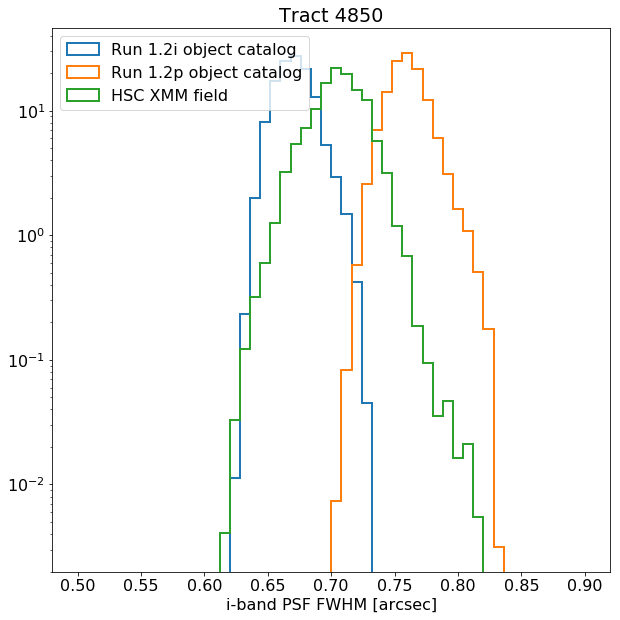

In [37]:
# Look at the image simulations and HSC (no truth): what is the distribution of PSF FWHM in i-band?
# These are not expected to match in any way, it's just useful information for interpreting the
# results for other quantities.
data_to_plot = [
                data_basic_i['psf_fwhm_i'],
                data_basic_p['psf_fwhm_i'],
                data_basic_h['psf_fwhm_i']
]
labels_to_plot = [
    'Run 1.2i object catalog',
    'Run 1.2p object catalog',
    'HSC XMM field'
]
plt.figure(figsize=(10,10))
plt.subplot(111)
myrange = [0.5,0.9]
plt.title('Tract %d'%tract_num)
for ind in range(len(data_to_plot)):
    plt.hist(data_to_plot[ind], nbins, range=myrange, histtype='step',
            label=labels_to_plot[ind], linewidth=2.0, density=True)
plt.legend(loc='upper left')
plt.xlabel('i-band PSF FWHM [arcsec]')
plt.yscale('log')

In this tract, it happens to be the case that the seeing is better in Run 1.2i than in HSC or Run 1.2p.  This is relevant to interpreting the PSF-convolved object sizes that are plotted later in this notebook.

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0,0.5,'i-band magnitude')

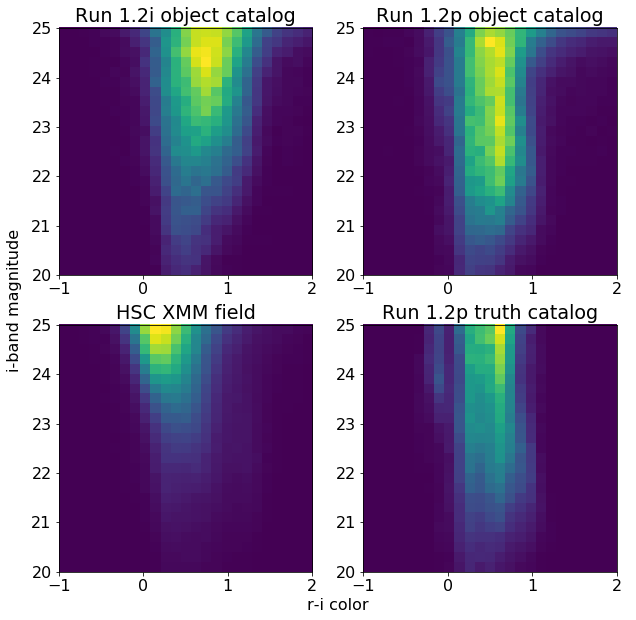

In [38]:
# Look at the observed r-i color versus i-band magnitude. (2D histograms)
data_x_to_plot = [
                data_basic_i['mag_r_cModel']-data_basic_i['mag_i_cModel'],
                data_basic_p['mag_r_cModel']-data_basic_p['mag_i_cModel'],
                data_basic_h['mag_r_cModel']-data_basic_h['mag_i_cModel'],
                truth_data_p['mag_r']-truth_data_p['mag_i']
]
data_y_to_plot = [
                data_basic_i['mag_i_cModel'],
                data_basic_p['mag_i_cModel'],
                data_basic_h['mag_i_cModel'],
                truth_data_p['mag_i']
]
labels_to_plot = [
    'Run 1.2i object catalog',
    'Run 1.2p object catalog',
    'HSC XMM field',
    'Run 1.2p truth catalog'
]
nbins_2d = 25
myrange = [[-1, 2], [20, 25]]
fig = plt.figure(figsize=(10,10))
for ind in range(len(data_x_to_plot)):
    ax = plt.subplot(2,2,ind+1)
    ax.hist2d(data_x_to_plot[ind], data_y_to_plot[ind], nbins_2d, range=myrange, normed=True)
    plt.title(labels_to_plot[ind])
# Overall axis label
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('r-i color')
plt.ylabel('i-band magnitude')

The above 4-panel plot shows the 2D distribution of the apparent r-i color (horizontal axis) and the apparent i-band magnitude (vertical axis).  The two right panels are Run 1.2p object (top) and truth (bottom).  On the left, the HSC plot will be replaced by a Run 1.2i truth table once it's ready.  Run 1.2i and HSC XMM cannot be fairly compared with each other or with Run 1.2p due various differences in the inputs.

Text(0.5,0,'i-band magnitude')

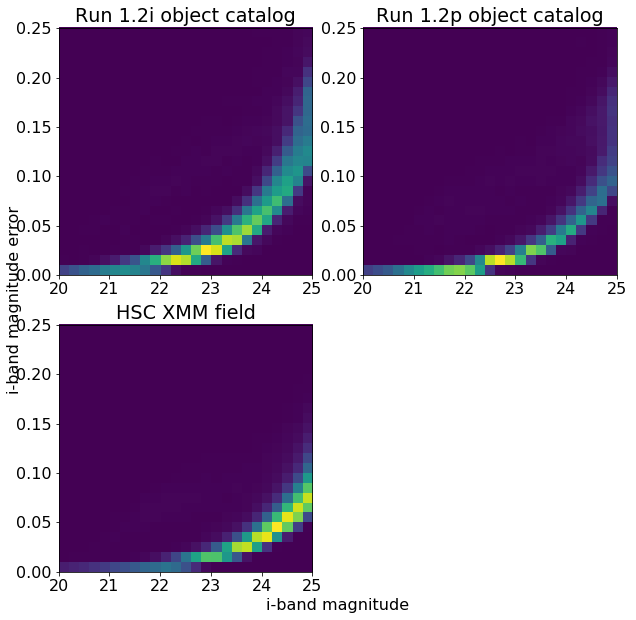

In [39]:
# For the image simulations and HSC (on truth), look at the 2D distribution of i-band magnitude vs.
# i-band magnitude uncertainty.  We expect fainter galaxies to have larger magnitude uncertainty.
data_x_to_plot = [
                data_basic_i['mag_i_cModel'],
                data_basic_p['mag_i_cModel'],
                data_basic_h['mag_i_cModel'],
]
data_y_to_plot = [
                data_basic_i['magerr_i_cModel'],
                data_basic_p['magerr_i_cModel'],
                data_basic_h['magerr_i_cModel'],
]
labels_to_plot = [
    'Run 1.2i object catalog',
    'Run 1.2p object catalog',
    'HSC XMM field'
]
myrange = [[20,25], [0,0.25]]
fig = plt.figure(figsize=(10,10))
for ind in range(len(data_x_to_plot)):
    ax = plt.subplot(2,2,ind+1)
    ax.hist2d(data_x_to_plot[ind], data_y_to_plot[ind], nbins_2d, range=myrange, normed=True)
    plt.title(labels_to_plot[ind])
# Overall axis label
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.ylabel('i-band magnitude error')
plt.xlabel('i-band magnitude')

In [40]:
# Calculate the determinant radius for the observed (PSF-convolved) galaxies.
i_det_size = (data_basic_i['Ixx_i']*data_basic_i['Iyy_i']-data_basic_i['Ixy_i']**2)**0.25
p_det_size = (data_basic_p['Ixx_i']*data_basic_p['Iyy_i']-data_basic_p['Ixy_i']**2)**0.25
h_det_size = (data_basic_h['Ixx_i']*data_basic_h['Iyy_i']-data_basic_h['Ixy_i']**2)**0.25

/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in power
  from ipykernel import kernelapp as app
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in power
  app.launch_new_instance()
/global/common/software/lsst/common/miniconda/current/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in power


Text(0,0.5,'Apparent radius [pixels]')

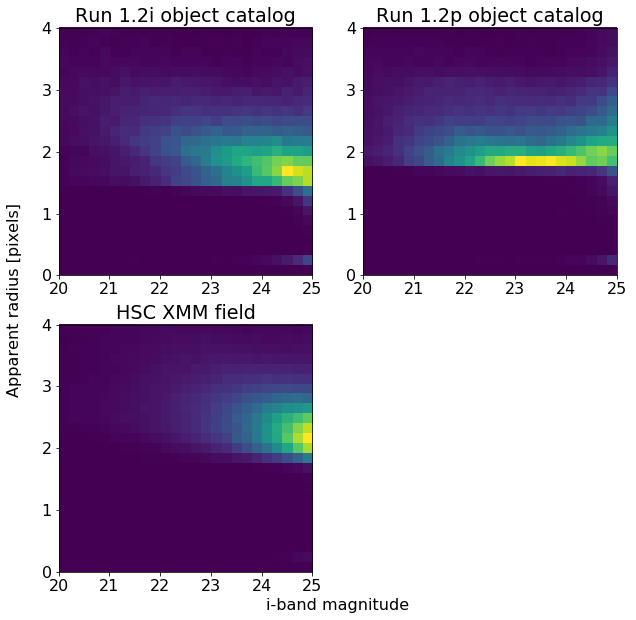

In [41]:
# Look at the apparent magnitude vs. apparent size trend line (includes PSF convolution).
# Units are pixels, so the sims vs. HSC comparison is not quite fair.
data_x_to_plot = [
                data_basic_i['mag_i_cModel'][np.isfinite(i_det_size)],
                data_basic_p['mag_i_cModel'][np.isfinite(p_det_size)],
                data_basic_h['mag_i_cModel'][np.isfinite(h_det_size)],
]
data_y_to_plot = [
                i_det_size[np.isfinite(i_det_size)],
                p_det_size[np.isfinite(p_det_size)],
                h_det_size[np.isfinite(h_det_size)],
]
labels_to_plot = [
    'Run 1.2i object catalog',
    'Run 1.2p object catalog',
    'HSC XMM field'
]
myrange = [[20,25], [0,4]]
fig = plt.figure(figsize=(10,10))
for ind in range(len(data_x_to_plot)):
    ax = plt.subplot(2,2,ind+1)
    ax.hist2d(data_x_to_plot[ind], data_y_to_plot[ind], nbins_2d, range=myrange, normed=True)
    plt.title(labels_to_plot[ind])
# Overall axis label
ax = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
plt.xlabel('i-band magnitude')
plt.ylabel('Apparent radius [pixels]')

In this final plot, we have the i-band magnitude (horizontal axis) versus the apparent radius in units of pixels, calculated as the determinant of the moment matrix of the PSF-convolved galaxies.  There are a few obvious features in this plot:

- In each panel, there is a lower cutoff in the values of the apparent radius.  The lower cutoff arises because of the PSF size.  For Run 1.2i, the PSF is smaller than in HSC or Run 1.2p, and so the cutoff is lower.

- For HSC and Run 1.2i, it's clear that there is a mild anti-correlation between magnitude and galaxy size, i.e., fainter galaxies are smaller.  In Run 1.2p this anticorrelation is not really apparent, but it could be because we're looking at a tract where the seeing is worse.